In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mehemmedhaciyev","key":"38713a17258cfda4d7a1f05214804bc0"}'}

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')


In [ ]:
! kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset
License(s): CC-BY-NC-SA-4.0
yes
yes


In [ ]:
import zipfile

with zipfile.ZipFile('/content/emotion-recognition-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import shutil

shutil.rmtree('/content/dataset/Ahegao') # folderi silmek ucundur

In [ ]:
import os

for dirpath, dirnames, filenames in os.walk('/content/dataset'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pathlib
import random

def view_random_image(target_dir, target_class):
    target_dir = pathlib.Path(target_dir) / target_class
    random_image = random.choice(os.listdir(target_dir))
    image_path = target_dir / random_image
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    return img.shape

In [ ]:
view_random_image(target_dir = '/content/dataset', target_class = 'Angry')

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)

data_path = '/content/dataset'

train_data = tf.keras.preprocessing.image_dataset_from_directory(data_path,
                                                                 image_size = IMG_SIZE,
                                                                 label_mode = 'categorical',
                                                                 subset = 'training',
                                                                 validation_split = 0.2,
                                                                 seed = 42,
                                                                 crop_to_aspect_ratio = True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(data_path,
                                                                image_size = IMG_SIZE,
                                                                label_mode = 'categorical',
                                                                subset = 'validation',
                                                                validation_split = 0.2,
                                                                seed = 42,
                                                                crop_to_aspect_ratio = True)

Found 14248 files belonging to 5 classes.
Using 11399 files for training.
Found 14248 files belonging to 5 classes.
Using 2849 files for validation.


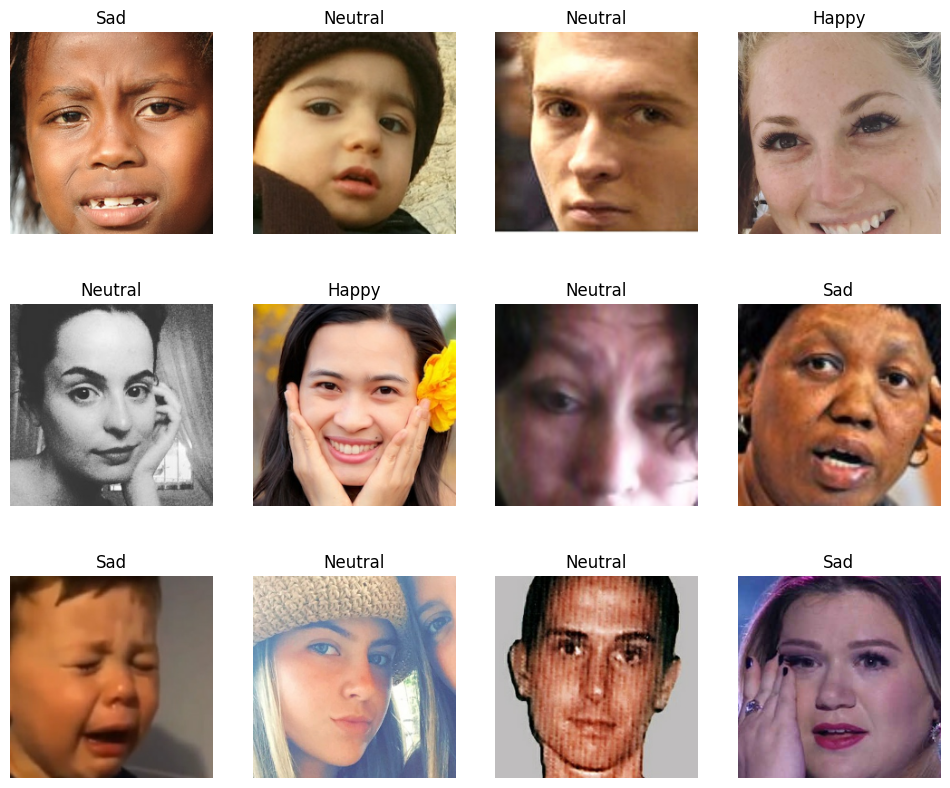

In [ ]:
import numpy as np

class_names = train_data.class_names

plt.figure(figsize = (12, 10))
for images, labels in train_data.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i] / 255)
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis('off')

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (224, 224, 3)),
    tf.keras.layers.Rescaling(1 / 255.),
    tf.keras.layers.Conv2D(64, kernel_size = 7, strides = 2, padding = 'same',
                           activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, kernel_size = 3, padding = 'same',
                           activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Conv2D(128, kernel_size = 3, padding = 'same',
                           activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, kernel_size = 3, padding = 'same',
                           activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Conv2D(256, kernel_size = 3, padding = 'same',
                           activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'softmax')

])

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history = model.fit(train_data, epochs = 5, validation_data = test_data)

In [ ]:
inputs = tf.keras.layers.Input(shape = (224, 224, 3))

x = tf.keras.applications.resnet50.preprocess_input(inputs)

base_model = tf.keras.applications.ResNet50(include_top = False, input_tensor = x)

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(5, activation = 'softmax')(avg)

model2 = tf.keras.Model(inputs = inputs, outputs = output)

In [ ]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 357,
    decay_rate = 0.96
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  patience = 3,
                                                  restore_best_weights = True)

chech_point = tf.keras.callbacks.ModelCheckpoint('best_model.keras',
                                                 monitor = 'val_loss',
                                                 save_best_only = True)

model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

history = model2.fit(train_data, epochs = 15, validation_data = test_data,
                     callbacks = [early_stopping, chech_point])

In [ ]:
def pred_and_plot(model, X, y):
    img=mpimg.imread(X)
    img=tf.image.resize(img, size=[224, 224])
    y_pred=model.predict(np.expand_dims(img, axis=0))

    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.imshow(img/255)
    plt.title(class_names[np.argmax(y_pred)])
    plt.axis(False)
    plt.subplot(1, 2, 2)
    plt.bar(class_names, y_pred[0])
    plt.title('Probability')
    plt.show()

pred_and_plot(model2, '/content/smiling-happy-girl-white-tshirt-260nw-1139754791.webp', 'Happy')


In [ ]:
base_model.trainable = False


model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

history = model2.fit(train_data, epochs = 15, validation_data = test_data,
                     callbacks = [early_stopping, chech_point])

In [ ]:
base_model.trainable = True

model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

history = model2.fit(train_data, epochs = 15, validation_data = test_data,
                     callbacks = [early_stopping, chech_point])